In [1]:
#   This software component is licensed by ST under BSD 3-Clause license,
#   the "License"; You may not use this file except in compliance with the
#   License. You may obtain a copy of the License at:
#                        https://opensource.org/licenses/BSD-3-Clause

# Acoustic Scene Classification

Artifical Intelligence can be used to classify ambiant noise captured by the microphone on an IoT device. This notebook shows how to create a Deep Learning Convolutional Neural Network to classify a sound input into three different categories:
- Indoor
- Outdoor
- In-Vehicle

This step-by-step notebook uses [Keras] for the model creation and trainning and [librosa] for audio preprocessing and feature extraction that can then be ported into the FP-AI-SENSING1 application example for STM32. 
![ASC Pipeline](./asc_pipeline.png)

[Keras]:https://keras.io/
[librosa]:https://librosa.github.io/

First, it is required to import a couple of libraries in order to run this notebook.

If some libraries are missing they can be installed using:
`!pip install <library-name>`

and/or upgraded using: `!pip install --upgrade <library-name>`

In [2]:
import numpy as np
import os
from tqdm import tqdm
import librosa
import librosa.display
import librosa.util
from IPython.display import Audio
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import keras.utils
from keras import layers
from keras import models
from keras import optimizers
import tensorflow as tf

Using TensorFlow backend.


In [3]:
print("Keras:", keras.__version__)
print("TensorFlow:",tf.__version__)
print("librosa:", keras.__version__)

Keras: 2.2.4
TensorFlow: 1.14.0
librosa: 2.2.4


## Import and Convert the Data
Only a limited subset of audio data is provided with this notebook. To build an actual application, it is recommend to use a complete dataset. For example, the [TUT Acoustic scenes 2016][1] dataset can be used. The dataset consists of recordings from various acoustic scenes, all having distinct recording locations. 

The dataset is expected to be located inside a folder named `Dataset` besides the Jupyter Notebook. The dataset should contain a metadata file where each line has a path to an audio file and a label separated by a space. *E.g*:
```
bus.wav bus
park.wav park
home.wav home
```
The original classes (bus, cafe/restaurant, car, ..) are then aggregated into more generic classes (indoor, outdoor, vehicle) for simplicity reasons.

When loaded into the runtime, the data is:
- resampled to **16kHz**
- converted to **mono**

__important:__ *Audio signal sampling rate and channel numbers settings should match the STM32 audio capture settings.* 

[1]: http://www.cs.tut.fi/sgn/arg/dcase2016/task-acoustic-scene-classification

In [4]:
dataset_dir = './Dataset'
meta_path = path = os.path.join(dataset_dir, 'TrainSet.txt')
fileset = np.loadtxt(meta_path, dtype=str)

# 3 classes : 0 indoor, 1 outdoor, 2 in-vehicle
class_names = ['indoor', 'outdoor', 'vehicle']
labels = {
    'bus' : 2,
    'cafeRestaurant' : 0,
    'car' : 2,
    'cityCenter' : 1,
    'home' : 0,
    'office' : 0,
    'park' : 1,
    'residentialArea' : 1,
    'shoppingCenter' : 0,
    'subway' : 2,
    'train' :  2,
    'tramway' :  2,
}

x = []
y = []

for file in tqdm(fileset):
    file_path, file_label = file
    file_path = os.path.join(dataset_dir, file_path)
    # @note: resampling can take some time!
    signal, _ = librosa.load(file_path, sr=16000, mono=True, duration=30, dtype=np.float32)
    label = labels[file_label]
    x.append(signal)
    y.append(label)

100%|██████████| 3/3 [00:00<00:00, 106.86it/s]


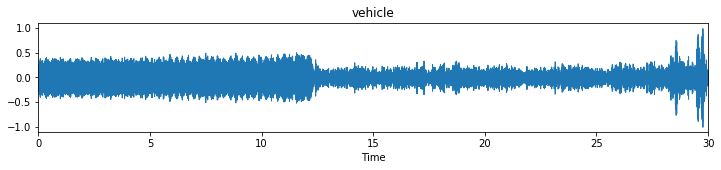

In [5]:
plt.figure(figsize=(12, 2))
plt.title(class_names[y[0]])
librosa.display.waveplot(x[0], sr=16000)
Audio(x[0], rate=16000)

## Prepare the Data
Instead of feeding raw audio data to the neural network model, the data is first sliced into smaller subframes in order to create a set of LogMel spectrograms 'features'. Theses features will then be used for the model training, validation and testing.

### Slice Data into frames
Each frame will contain 16,896 samples (32 * 512 + 512) to create a 32 column spectrogram with n_fft=1024 and hop_length=512

In [6]:
x_framed = []
y_framed = []

for i in range(len(x)):
    frames = librosa.util.frame(x[i], frame_length=16896, hop_length=512)
    x_framed.append(np.transpose(frames))
    y_framed.append(np.full(frames.shape[1], y[i]))
    
# merge sliced frames and label
x_framed = np.asarray(x_framed)
y_framed = np.asarray(y_framed)
x_framed = x_framed.reshape(x_framed.shape[0]*x_framed.shape[1], x_framed.shape[2])
y_framed = y_framed.reshape(y_framed.shape[0]*y_framed.shape[1], )

print("x_framed shape: ", x_framed.shape) # Each frame of 16,896 samples can be used to create spectrogram 
print("y_framed shape: ", y_framed.shape) # Corresponding label for each frame


x_framed shape:  (2715, 16896)
y_framed shape:  (2715,)


### Preprocess the Data into LogMel Spectrograms
Create a feature set using log-melspectrogram feature extraction.

__important:__ *preprocessing parameters should match the psrameters defined in the STM32 implementation*    

In [7]:
x_features = []
y_features = y_framed

for frame in tqdm(x_framed):
    # Create a mel-scaled spectrogram
    S_mel = librosa.feature.melspectrogram(y=frame, sr=16000, n_mels=30, n_fft=1024, hop_length=512, center=False)
    # Scale according to reference power
    S_mel = S_mel / S_mel.max()
    # Convert to dB
    S_log_mel = librosa.power_to_db(S_mel, top_db=80.0)
    x_features.append(S_log_mel)

# Convert into numpy array
x_features = np.asarray(x_features)

100%|██████████| 2715/2715 [00:12<00:00, 218.58it/s]


We get 2,715 features in the set, with each feature represented with a 30x32 spectrogram. 

In [8]:
print(x_features.shape)

(2715, 30, 32)


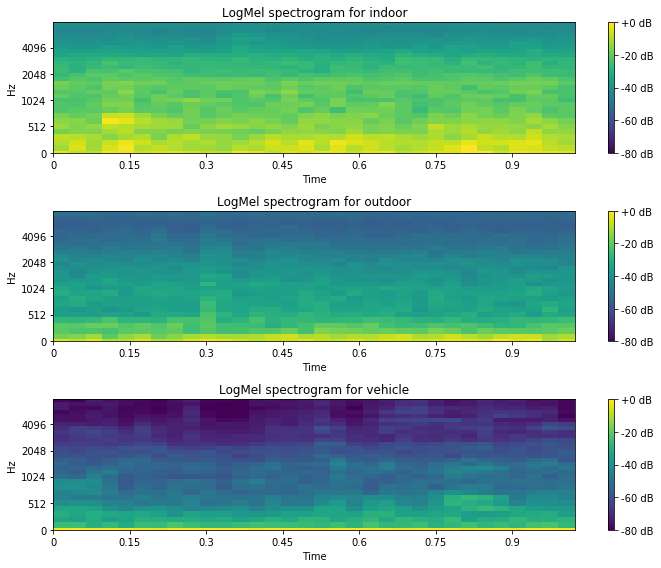

In [9]:
# Plot the first spectrogram generated for each feature class

plt.figure(figsize=(10, 8))
plt.subplot(311)
indoor_index = np.argmax(y_framed == 0)
librosa.display.specshow(x_features[indoor_index], sr=16000, y_axis='mel', fmax=8000,
                         x_axis='time', cmap='viridis', vmin=-80.0)
plt.colorbar(format='%+2.0f dB')
plt.title('LogMel spectrogram for ' + class_names[y_features[indoor_index]])

plt.subplot(312)
outdoor_index = np.argmax(y_framed == 1)
librosa.display.specshow(x_features[outdoor_index], sr=16000, y_axis='mel', fmax=8000,
                         x_axis='time', cmap='viridis', vmin=-80.0)
plt.colorbar(format='%+2.0f dB')
plt.title('LogMel spectrogram for ' + class_names[y_features[outdoor_index]])

plt.subplot(313)
vehicle_index = np.argmax(y_framed == 2)
librosa.display.specshow(x_features[vehicle_index], sr=16000, y_axis='mel', fmax=8000,
                         x_axis='time', cmap='viridis', vmin=-80.0)
plt.colorbar(format='%+2.0f dB')
plt.title('LogMel spectrogram for ' + class_names[y_features[vehicle_index]])

plt.tight_layout()
plt.show()

## Standardize features
Standardize features by removing the mean and scaling to unit variance

The standard score of a sample x is calculated as:

z = (x - u) / s

where u is the mean of the training samples, and s is the standard deviation of the training samples.

Ref: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html 


In [10]:
# Flatten features for scaling
x_features_r = np.reshape(x_features, (len(x_features), 30 * 32))

# Create a feature scaler
scaler = preprocessing.StandardScaler().fit(x_features_r)

# Apply the feature scaler 
x_features_s = scaler.transform(x_features_r)

## Prepare output data
And each feature has a matching label, but keras requires categorical one-hot encoded target label data. So let's convert the labels to the desired encoding:

In [11]:
# Convert labels to categorical one-hot encoding
y_features_cat = keras.utils.to_categorical(y_features, num_classes=len(class_names))

print("y_features_cat shape: " ,y_features_cat.shape)

y_features_cat shape:  (2715, 3)


## Split the dataset into train, validation, and test set
When training, we want to check the accuracy of the model on data it hasn't seen before. So we wan to split the  dataset into a training and validation set to evaluate the loss and other model metrics at the end of each training epoch. The goal is to develop and tune the model using only the training and validation data. The test set will only be used for final evaluation as if it was unknown, new data.

Ref: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_features_s,
                                                    y_features_cat,
                                                    test_size=0.25,
                                                    random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.25,
                                                  random_state=1)

print('Training samples:', x_train.shape)
print('Validation samples:', x_val.shape)
print('Test samples:', x_test.shape)

Training samples: (1527, 960)
Validation samples: (509, 960)
Test samples: (679, 960)


## (Optional) Save the Features
Finally, save the features to a csv file in a format [X-CUBE-AI](https://www.st.com/en/embedded-software/x-cube-ai.html) can understand,
that is, for each tensor, the values are in a flattened vector.

In [13]:
out_dir = './Output/'
np.savetxt(out_dir + 'x_train.csv', x_train.reshape(len(x_train), 30 * 32), delimiter=",")
np.savetxt(out_dir + 'y_train.csv', y_train, delimiter=",")
np.savetxt(out_dir + 'x_val.csv', x_val.reshape(len(x_val), 30 * 32), delimiter=",")
np.savetxt(out_dir + 'y_val.csv', y_val, delimiter=",")
np.savetxt(out_dir + 'x_test.csv', x_test.reshape(len(x_test), 30 * 32), delimiter=",")
np.savetxt(out_dir + 'y_test.csv', y_test, delimiter=",")

## Build the Model
Now, let's build a sequential convolutional network classifier model: 

In [14]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(30, 32, 1), data_format='channels_last'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

# print model summary
model.summary()

W1024 11:46:37.581811 437772 deprecation_wrapper.py:119] From c:\users\legraing\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1024 11:46:37.628398 437772 deprecation_wrapper.py:119] From c:\users\legraing\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1024 11:46:37.639928 437772 deprecation_wrapper.py:119] From c:\users\legraing\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1024 11:46:37.706103 437772 deprecation_wrapper.py:119] From c:\users\legraing\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 30, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 13, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 5193      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 30        
Total para

## Compile the Model

In [15]:
sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy',  metrics=['acc'])

W1024 11:46:38.060546 437772 deprecation_wrapper.py:119] From c:\users\legraing\appdata\local\programs\python\python36\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1024 11:46:38.096142 437772 deprecation_wrapper.py:119] From c:\users\legraing\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



## Train the Model
Now it's time to feed training data into our model. This is where a powerful CPU or even a GPU is recommended for this task.

In [16]:
# Reshape features to include channel
x_train_r = x_train.reshape(x_train.shape[0], 30, 32, 1)
x_val_r = x_val.reshape(x_val.shape[0], 30, 32, 1)
x_test_r = x_test.reshape(x_test.shape[0], 30, 32, 1)

In [17]:
# Train the model
history = model.fit(x_train_r, y_train, validation_data=(x_val_r, y_val),
                    batch_size=500, epochs=20, verbose=2)

W1024 11:46:38.457102 437772 deprecation.py:323] From c:\users\legraing\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1024 11:46:38.611543 437772 deprecation_wrapper.py:119] From c:\users\legraing\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 1527 samples, validate on 509 samples
Epoch 1/20
 - 1s - loss: 1.1044 - acc: 0.0923 - val_loss: 1.0491 - val_acc: 0.3536
Epoch 2/20
 - 1s - loss: 1.0270 - acc: 0.3340 - val_loss: 0.9255 - val_acc: 0.3733
Epoch 3/20
 - 1s - loss: 0.8642 - acc: 0.4204 - val_loss: 0.7045 - val_acc: 0.7701
Epoch 4/20
 - 1s - loss: 0.7000 - acc: 0.7669 - val_loss: 0.5970 - val_acc: 0.8173
Epoch 5/20
 - 1s - loss: 0.5826 - acc: 0.8199 - val_loss: 0.4428 - val_acc: 0.8861
Epoch 6/20
 - 1s - loss: 0.4234 - acc: 0.8880 - val_loss: 0.3046 - val_acc: 0.9214
Epoch 7/20
 - 1s - loss: 0.2979 - acc: 0.9312 - val_loss: 0.2064 - val_acc: 0.9725
Epoch 8/20
 - 1s - loss: 0.1930 - acc: 0.9731 - val_loss: 0.1099 - val_acc: 0.9902
Epoch 9/20
 - 1s - loss: 0.1014 - acc: 0.9915 - val_loss: 0.0545 - val_acc: 1.0000
Epoch 10/20
 - 1s - loss: 0.0529 - acc: 0.9987 - val_loss: 0.0282 - val_acc: 1.0000
Epoch 11/20
 - 1s - loss: 0.0294 - acc: 0.9987 - val_loss: 0.0157 - val_acc: 1.0000
Epoch 12/20
 - 1s - loss: 0.0180 - acc

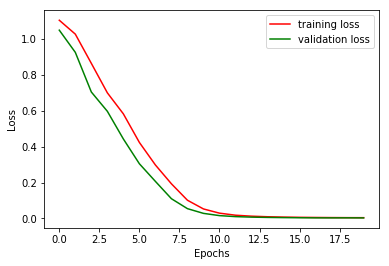

In [18]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.clf()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss, color='r', label='training loss')
plt.plot(val_loss, color='g', label='validation loss')
plt.legend()

## Evaluate Accuracy
Next, compare how the model performs on the test dataset:

In [19]:
print('Evaluate model:')
results = model.evaluate(x_test_r, y_test)
print(results)
print('Test loss: {:f}'.format(results[0]))
print('Test accuracy: {:.2f}%'.format(results[1] * 100))

Evaluate model:
679/679 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 292us/step
[0.0033203214310954525, 1.0]
Test loss: 0.003320
Test accuracy: 100.00%


Overfitting is when a machine learning model performs worse on new data than on their training data.

## Confusion Matrix

Accuracy = 100.00%


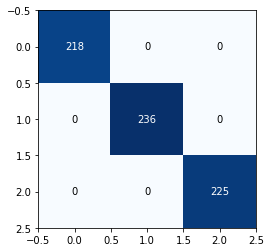

In [20]:
y_pred = model.predict(x_test_r)

y_pred_class_nb = np.argmax(y_pred, axis=1)
y_true_class_nb = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_class_nb, y_pred_class_nb)
np.set_printoptions(precision=2)
print("Accuracy = {:.2f}%".format(accuracy * 100))

cm = confusion_matrix(y_true_class_nb, y_pred_class_nb, labels=[0,1,2])

# (optional) normalize to get values in %
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.imshow(cm, cmap=plt.cm.Blues)

## Save the model
When saving the model in a `.h5` file format, the [X-CUBE-AI](https://www.st.com/en/embedded-software/x-cube-ai.html) tool can import the pre-training model and generate an equivalent C model optmized for STM32 devices. 

In [21]:
# Save the model into an HDF5 file ‘model.h5’
model.save(out_dir + 'model.h5')

## (Optional) Convert Model TFlite with Quantization
Further optimization can be achived using the TensorFlowLite converter. Model size will be reduced at the cost of accuracy. 

Ref:
- https://www.tensorflow.org/versions/r1.14/api_docs/python/tf/lite/TFLiteConverter
- https://www.tensorflow.org/lite/performance/post_training_quantization

In [22]:
x_train_r.shape

(1527, 30, 32, 1)

In [23]:
def representative_dataset_gen():
    for i in range(len(x_train_r)):
        yield [x_train_r[i].reshape((1, ) + x_train_r[i].shape)]


converter = tf.lite.TFLiteConverter.from_keras_model_file(out_dir + "model.h5" )
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open(out_dir + 'model.tflite','wb') as f:
    f.write(tflite_model)
    print("TFlite model saved")

W1024 11:46:57.122369 437772 deprecation.py:323] From c:\users\legraing\appdata\local\programs\python\python36\lib\site-packages\tensorflow\lite\python\util.py:238: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W1024 11:46:57.125878 437772 deprecation.py:323] From c:\users\legraing\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


TFlite model saved


## References
- https://www.tensorflow.org/tutorials/keras/basic_classification
- https://www.tensorflow.org/tutorials/keras/basic_text_classification
- https://www.tensorflow.org/tutorials/sequences/audio_recognition